<a href="https://colab.research.google.com/github/abhayraghuwanshi/Is-Api-Safe/blob/main/Monoxor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Data Import</h1>

In [ ]:
import json
import pandas as pd
import requests
import numpy as np

In [ ]:
url = "https://jsonblob.com/api/jsonBlob/f0b70eef-566b-11eb-9d92-415b3ac53928"

In [ ]:
response = requests.get(url)

In [ ]:
payload = response.json()

In [ ]:
def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

In [ ]:
for index, data in enumerate(payload):
  payload[index] = flatten_json(data)

In [ ]:
data = pd.DataFrame(payload)

In [ ]:
data.head()

,req_baseUrl,req_body_note_title,req_body_note_desc,req_fresh,req_headers_host,req_headers_user-agent,req_headers_content-type,req_headers_org_id,req_headers_user_session_id,req_headers_accept,req_headers_content-length,req_headers_user_name,req_headers_user_role,req_hostname,req_ip,req_originalUrl,req_path,req_protocol,req_secure,req_stale,req_subdomains_0,req_xhr,isSafe
0,/crm/note,Tina Johnson,Top recognize eat. Fact whom spend area thing ...,False,example.com,insomnia/2020.4.2,application/json,5f572820f65af8ac955b2e83,5fb27d3750b11901a35649fe,*/*,70,sam,sales1,example.com,::ffff:117.99.96.244,/crm/note,/note,http,False,True,crm,False,True
1,/crm/note,Clayton Cooper,As possible American many prepare four strong....,False,example.com,insomnia/2020.4.2,application/json,5f572820f65af8ac955b2e83,5fb27d3750b11901a35649fe,*/*,70,sam,sales1,example.com,::ffff:117.99.96.244,/crm/note,/note,http,False,True,crm,False,True
2,/crm/note,Curtis Wolfe,Tuesday Notes or 2 like 2 XSP Class,False,example.com,insomnia/2020.4.2,application/json,5f572820f65af8ac955b2e83,5fb27d3750b11901a35649fe,*/*,70,sam,sales1,example.com,::ffff:117.99.96.244,/crm/note,/note,http,False,True,crm,False,False
3,/crm/note,Laura Fisher,State third represent energy campaign not forg...,False,example.com,insomnia/2020.4.2,application/json,5f572820f65af8ac955b2e83,5fb27d3750b11901a35649fe,*/*,70,sam,sales1,example.com,::ffff:117.99.96.244,/crm/note,/note,http,False,True,crm,False,True
4,/crm/note,Tyler Santos,Us enjoy since. Time identify image position o...,False,example.com,insomnia/2020.4.2,application/json,5f572820f65af8ac955b2e83,5fb27d3750b11901a35649fe,*/*,70,sam,sales1,example.com,::ffff:117.99.96.244,/crm/note,/note,http,False,True,crm,False,False


In [ ]:
for col in data.columns:
  print(col, data[col].nunique())

req_baseUrl 1
req_body_note_title 994
req_body_note_desc 750
req_fresh 1
req_headers_host 1
req_headers_user-agent 1
req_headers_content-type 1
req_headers_org_id 1
req_headers_user_session_id 1
req_headers_accept 1
req_headers_content-length 1
req_headers_user_name 1
req_headers_user_role 1
req_hostname 1
req_ip 1
req_originalUrl 1
req_path 1
req_protocol 1
req_secure 1
req_stale 1
req_subdomains_0 1
req_xhr 1
isSafe 2


In [ ]:
data.isSafe.value_counts()

True     572
False    428
Name: isSafe, dtype: int64

<h3> TEXT CLEANING </h3>

In [ ]:
!pip install unidecode
!pip install word2number

     |████████████████████████████████| 245kB 5.4MB/s 
  Created wheel for word2number: filename=word2number-1.1-cp36-none-any.whl size=5588 sha256=81b4def4325d614748ea4b67156c8e2b0f0927814d67dc2c365d42c671ad9c3d
  Stored in directory: /root/.cache/pip/wheels/46/2f/53/5f5c1d275492f2fce1cdab9a9bb12d49286dead829a4078e0e
Successfully built word2number


In [ ]:
pip install contractions

     |████████████████████████████████| 317kB 5.9MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81690 sha256=630982b4d32dad6f80326f564d31cc7d35c1b4417412a7b8676248703edb0b14
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [ ]:
from textblob import TextBlob
from textblob import Word
import unidecode
from bs4 import BeautifulSoup
import string
from word2number import w2n
import re
import spacy
import contractions as con

In [ ]:
def text_cleaning(text):
    
    def remove_extra_space(text):
        return re.sub("\s\s+" , " ", text)
    
    def strip_html_tags(text):
        """remove html tags from text"""
        soup = BeautifulSoup(text, "html.parser")
        stripped_text = soup.get_text(separator=" ")
        return stripped_text

    def remove_punct(text):
        """ removing these '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' """
        text_clean = "".join([i.lower() for i in text if i not in string.punctuation])
        return text_clean

    def remove_accented_chars(text):
        """remove accented characters from text, e.g. café"""
        text = unidecode.unidecode(text)
        return text
    
    def remove_contractions(text):
        return con.fix(text)
    
    def remove_links(text):
        return re.sub('http://\S+|https://\S+', "", text)
                      
    def deEmojify(text):
        regrex_pattern = re.compile(pattern = "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags = re.UNICODE)
        return regrex_pattern.sub(r'',text)
    
    def remove_numbers(text):
        output = ''.join(c for c in text if not c.isdigit())
        return output
    
    ct = deEmojify(text)
    ct = remove_contractions(ct)
    ct = strip_html_tags(ct)
    ct = remove_accented_chars(ct)
    ct = remove_punct(ct)
    ct = remove_extra_space(ct)
    ct = remove_numbers(ct)
    return ct

In [ ]:
cleaned_data = data['req_body_note_desc'].apply(lambda x: text_cleaning(x))

<h3> Pre Processing </h3>

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def lemmatizing(text):
    tokens = word_tokenize(text)
    lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
    result = [i for i in lemmatized_word if not i in stop_words]
    return result

In [ ]:
raw_train = cleaned_data.apply(lambda x: lemmatizing(x))

In [ ]:
raw_train

0      [top, recognize, eat, fact, spend, area, thing...
1      [possible, american, many, prepare, four, stro...
2                      [tuesday, note, like, xsp, class]
3      [state, third, represent, energy, campaign, fo...
4      [u, enjoy, since, time, identify, image, posit...
                             ...                        
995    [recently, crime, five, thought, bit, card, fo...
996                                                   []
997    [set, nature, low, resource, truth, edge, rece...
998    [push, case, face, suffer, letter, middle, ter...
999    [family, ready, stay, rule, full, yet, moment,...
Name: req_body_note_desc, Length: 1000, dtype: object

In [ ]:
unique_words = set()
len_max = 0

for sent in raw_train:
    
    unique_words.update(sent) # update the set with the list in the sent.
    
    if(len_max<len(sent)):
        len_max = len(sent)

In [ ]:
print(len_max, len(unique_words))

31 878


<h3>Train test Split </h3>

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
 X_train, X_test, y_train, y_test  = train_test_split(raw_train, data['isSafe'].astype(int), test_size=0.2, random_state=42)

 X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [ ]:
import tensorflow as tf 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
x_train_list = list(X_train)
tokenizer.fit_on_texts(list(x_train_list))

#texts_to_sequences(texts)

# Arguments- texts: list of texts to turn to sequences.
  #Return: list of sequences (one per text input).
X_train = tokenizer.texts_to_sequences(X_train)
X_test =  tokenizer.texts_to_sequences(X_test)
X_val =  tokenizer.texts_to_sequences(X_val)

In [ ]:
X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=int(len_max))
X_val = sequence.pad_sequences(X_val, maxlen=int(len_max))

<h2>Model</h2>

In [ ]:
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D, LSTM, SpatialDropout1D, Bidirectional, GRU, GlobalAveragePooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, SGD

In [ ]:
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.005),metrics=["binary_accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 300)           263400    
_________________________________________________________________
lstm (LSTM)                  (None, 31, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 539,057
Trainable params: 539,057
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
10/10 [==============================] - 3s 252ms/step - loss: 1.5291e-04 - binary_accuracy: 1.0000 - val_loss: 2.7090 - val_binary_accuracy: 0.7750
Epoch 2/10
10/10 [==============================] - 2s 248ms/step - loss: 3.2922e-05 - binary_accuracy: 1.0000 - val_loss: 2.7371 - val_binary_accuracy: 0.7750
Epoch 3/10
10/10 [==============================] - 2s 245ms/step - loss: 1.0677e-05 - binary_accuracy: 1.0000 - val_loss: 2.7521 - val_binary_accuracy: 0.7750
Epoch 4/10
10/10 [==============================] - 2s 246ms/step - loss: 1.0847e-05 - binary_accuracy: 1.0000 - val_loss: 2.7622 - val_binary_accuracy: 0.7750
Epoch 5/10
10/10 [==============================] - 2s 247ms/step - loss: 1.3424e-05 - binary_accuracy: 1.0000 - val_loss: 2.7720 - val_binary_accuracy: 0.7750
Epoch 6/10
10/10 [==============================] - 2s 249ms/step - loss: 3.5898e-05 - binary_accuracy: 1.0000 - val_loss: 2.7825 - val_binary_accuracy: 0.7750
Epoch 7/10
10/10 [======================

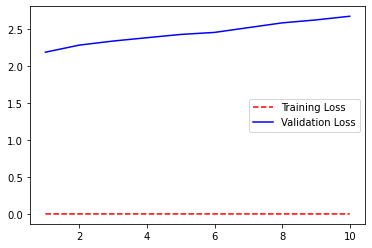

In [ ]:
# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)
import matplotlib.pyplot as plt

# Visualize learning curve. Here learning curve is not ideal.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])

In [ ]:
pred = model.predict(X_test)

In [ ]:
pred = (pred >= 0.5).astype(int)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix, f1_score

In [ ]:
cf_matrix = confusion_matrix(y_test, pred)

In [ ]:
import seaborn as sns

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')